### Instagram

In [138]:
%pylab inline

client_id = ''
client_secret = ''

from instagram.client import InstagramAPI
api = InstagramAPI(client_id=client_id, client_secret=client_secret)

In [139]:
tag = 'NationalKaleDay'
print api.tag(tag).media_count

# get ig media based on tag

max_tag_id = 0
media_per_query = 33
MAX_ITEMS = 10000

all_media, next_ = api.tag_recent_media(media_per_query, max_tag_id, tag)

while next_:
    more_media, next_ = api.tag_recent_media(count=media_per_query, tag_name=tag, with_next_url=next_)
    all_media.extend(more_media)
        
    #print len(all_media)
    if len(all_media)>MAX_ITEMS:
        break

3970


In [140]:
# create a dataframe and add the Instagram data we just collected
import pandas as pd

df = pd.DataFrame({
        'times':[m.created_time for m in all_media], 
        'users':[m.user.username for m in all_media]
    })

In [141]:
# since we need hourly counts, let's create a function that sets the second/minute value to zero
def make_date(d):
    d = d.replace(second=0, minute=0)
    return d

df['dt']=df[['times']].apply(lambda x: make_date(x['times']), axis=1)
ig_df = df.set_index('dt')

In [142]:
# now we have everything we need in our dataframe
ig_df.head()

,times,users
dt,,
2015-10-07 19:00:00,2015-10-07 19:49:29,alicia1398
2015-10-07 19:00:00,2015-10-07 19:49:08,rackedup_jota
2015-10-07 19:00:00,2015-10-07 19:49:05,seanyp_21
2015-10-07 19:00:00,2015-10-07 19:48:49,letthecolorout
2015-10-07 19:00:00,2015-10-07 19:48:07,suma_haque


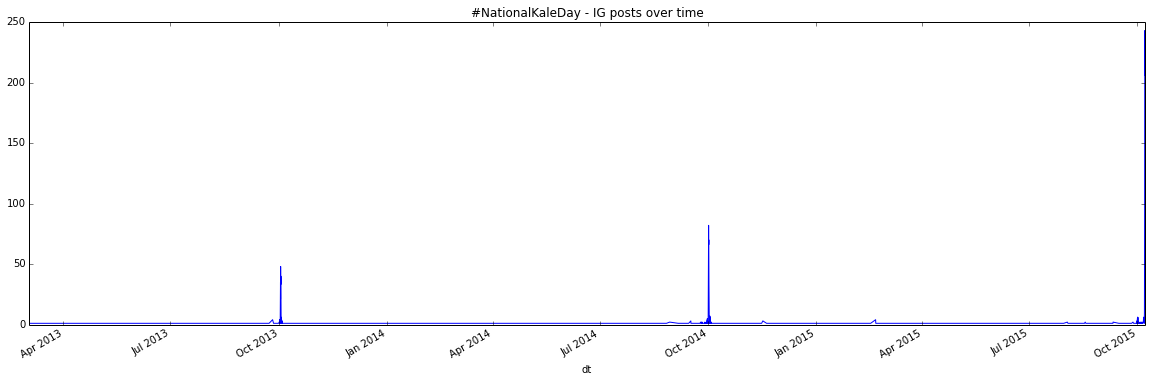

In [143]:
# let's plot it over time, group by hour, which is effectively our 'dt' column (or the index in this case)

df.groupby(df.dt).size().plot(figsize=(20,6))
title('#%s - IG posts over time' % tag)

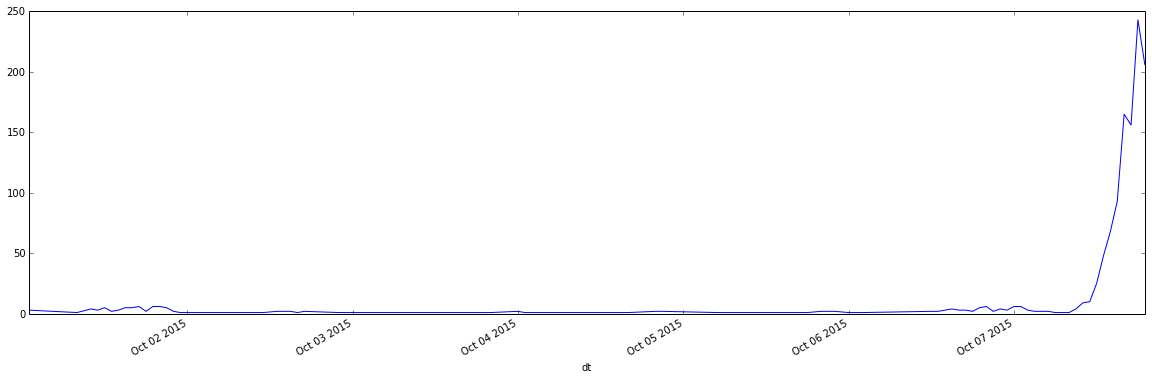

In [145]:
# slice only the past week -> since Twitter only lets us search back for a week
ig_df.groupby(ig_df.index).size()['2015-10-01':].plot(figsize=(20,6))

### Twitter

In [98]:
# pip install twitter
import twitter

# Twitter API keys go here
CONSUMER_KEY = ''
CONSUMER_SECRET = ''

OAUTH_TOKEN = ''
OAUTH_TOKEN_SECRET = ''


auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth)

In [106]:
# here's how we make a basic call to twitter search -> given a query that's a hashtag
search_results = twitter_api.search.tweets(q='#'+tag, count=count)

In [100]:
# the results have a metadata portion which gives us all the information we need for further pagination 
search_results['search_metadata']

{u'completed_in': 0.246,
 u'count': 100,
 u'max_id': 651844101697085440,
 u'max_id_str': u'651844101697085440',
 u'next_results': u'?max_id=651840037038985215&q=%23NationalKaleDay&count=100&include_entities=1',
 u'query': u'%23NationalKaleDay',
 u'refresh_url': u'?since_id=651844101697085440&q=%23NationalKaleDay&include_entities=1',
 u'since_id': 0,
 u'since_id_str': u'0'}

In [ ]:
# we need to parse the 'max_id' value from the 'next_results' item (in order to paginate through the next results)

def parse_twitter_next(_metadata):
    try:
        params = {a:b for a,b in [x.split('=') for x in _metadata['next_results'][1:].split('&')]}
        return int(params['max_id'])
    except:
        return None    

In [107]:
# our newly created function works!! (extracts the value of the max_id variable in the 'next_results' url)
parse_twitter_next(search_results['search_metadata'])

651840037038985215

In [108]:
# paginate through Twitter results -> GET ALL THE DATA!
num_iterations = 30
count = 100

search_results = twitter_api.search.tweets(q='#'+tag, count=count)
statuses = search_results['statuses']

for i in range(num_iterations):
    max_id = parse_twitter_next(search_results['search_metadata'])   
    search_results = twitter_api.search.tweets(q='#'+tag, count=count, max_id=max_id)
    statuses += search_results['statuses']

print len(statuses)

3041


In [129]:
# create a DataFrame to hold the tweets
tw_df = pd.DataFrame({
        'times':[s['created_at'] for s in statuses], 
        'users':[s['user']['screen_name'] for s in statuses]
    })

In [130]:
tw_df.head()

,times,users
0,Wed Oct 07 19:44:50 +0000 2015,ronfeir
1,Wed Oct 07 19:44:38 +0000 2015,Frantzesq
2,Wed Oct 07 19:44:28 +0000 2015,RobertKoss
3,Wed Oct 07 19:44:26 +0000 2015,SchoolMealsRock
4,Wed Oct 07 19:44:06 +0000 2015,heyyy1D_


In [135]:
# Here its a bit more complicated - we need to parse the date string into a datetime object, which we can then
# use to set our second/minute value to zero (just like we did above for instagram)

from datetime import datetime

def make_tw_date(dt_str):
    d = datetime.strptime(dt_str, '%a %b %d %H:%M:%S +0000 %Y')
    d = d.replace(second=0, minute=0)
    return d

tw_df['dt']=tw_df[['times']].apply(lambda x: make_tw_date(x['times']), axis=1)
tw_df = tw_df.set_index('dt')

### Merge Two DataFrames

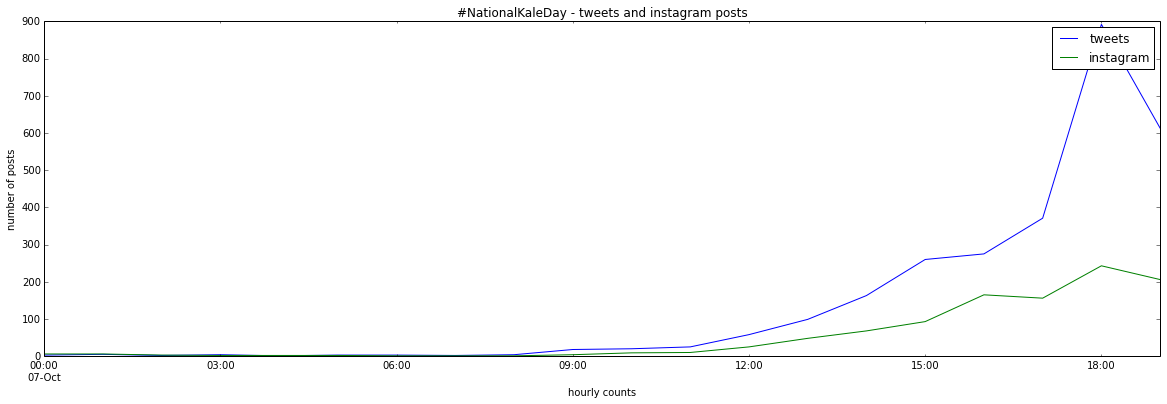

In [144]:
tw_df.groupby(tw_df.index).size()['2015-10-07':].plot(figsize=(20,6), label='tweets')
ig_df.groupby(ig_df.index).size()['2015-10-07':].plot(figsize=(20,6), label='instagram')
legend()
title('#%s - tweets and instagram posts' % tag)
xlabel('hourly counts')
ylabel('number of posts')